# Exploratory Analysis for NOAA Weather and Climate Dataset

In this notebook, we go through basic steps of exploratory data analysis (EDA), performing initial data investigations to discover patterns, spot anomalies, and look for insights to inform later ML modeling choices.

We will use some daily weather data from a NOAA (National Oceanic and Atmospheric Administration) station in Asheville, NC. A full description of this dataset is available at:

https://www.ncei.noaa.gov/pub/data/uscrn/products/daily01/

## Install all necessary packages

Before you import these packages, you need to right-click on the `eng_eda.yml` file that ships with this notebook, and select "Build Conda Environment." It looks like this.

![](images/build_conda_env.png)

This should open a new terminal, which will run the following commands:
- `conda env create -f env_eda.yml`
- `conda activate eda`

After that, you needto switch the notebook kernel. In the top righthand cornder of this notebook, click on default:Python and change to to **.conda-eda:Python**

![](images/select_kernel.png)

In [2]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import datetime
import zipfile
import importlib
import subprocess
import sys
import os
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Prerequisites panda update to 1.0.5 version
if pd.__version__ < '1.0.5':
    subprocess.check_call([sys.executable, '-m', 'conda', 'install', '-y', 'pandas==1.0.5'])
    importlib.reload(pd)

## Downloading the dataset

In [4]:
data_base = 'data/daily01/'
url_base = 'https://www.ncei.noaa.gov/pub/data/uscrn/products/daily01/snapshots/'
dataset_zip = 'CRND0103-202110250450.zip'
if not os.path.isdir(data_base):
    !mkdir -p {data_base}
    
# Download dataset from NOAA website
if not os.path.isfile(data_base+dataset_zip):
    !wget --no-check-certificate {url_base}{dataset_zip}
    !mv {dataset_zip} {data_base}

# Uncompress the dataset
if not os.path.isfile(data_base+'HEADERS.txt'):
    print("Uncompressing the dataset")
    with zipfile.ZipFile(data_base+dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(data_base)    

--2021-11-24 22:10:19--  https://www.ncei.noaa.gov/pub/data/uscrn/products/daily01/snapshots/CRND0103-202110250450.zip
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.167, 205.167.25.168, 205.167.25.171, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32186912 (31M) [application/zip]
Saving to: 'CRND0103-202110250450.zip'

CRND0103-2021102504 100%[===================>]  30.70M  33.2MB/s    in 0.9s    

2021-11-24 22:10:20 (33.2 MB/s) - 'CRND0103-202110250450.zip' saved [32186912/32186912]

Uncompressing the dataset


## Overall Statistics

### Variables list

In [5]:
with open(data_base + "HEADERS.txt") as file:  
    data = file.read()
lines = data.split('\n')   
headers = lines[1].split(' ')[:-1]
print(headers)

['WBANNO', 'LST_DATE', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'T_DAILY_MAX', 'T_DAILY_MIN', 'T_DAILY_MEAN', 'T_DAILY_AVG', 'P_DAILY_CALC', 'SOLARAD_DAILY', 'SUR_TEMP_DAILY_TYPE', 'SUR_TEMP_DAILY_MAX', 'SUR_TEMP_DAILY_MIN', 'SUR_TEMP_DAILY_AVG', 'RH_DAILY_MAX', 'RH_DAILY_MIN', 'RH_DAILY_AVG', 'SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY', 'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY']


### Reading three years of data from Asheville, NC

In [6]:
dframes = []
for year in range(2017, 2020):
    data_file = f'{year}/CRND0103-{year}-NC_Asheville_13_S.txt'               
    df = pd.read_csv(data_base + data_file, parse_dates=[1],
                     names=headers, header=None, sep='\s+',
                     na_values=[-9999.0, -99.0])
    dframes.append(df)

df = pd.concat(dframes, ignore_index=True)

In [7]:
df.head()

,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53878,2017-01-01,2.422,-82.56,35.42,11.7,4.9,8.3,7.6,0.6,...,0.196,0.213,0.239,0.308,0.331,6.8,6.7,7.0,8.5,10.8
1,53878,2017-01-02,2.422,-82.56,35.42,12.2,7.2,9.7,9.4,13.0,...,0.237,0.235,0.250,0.308,0.331,8.6,8.4,8.3,8.6,10.7
2,53878,2017-01-03,2.422,-82.56,35.42,16.5,8.0,12.3,10.9,9.7,...,0.262,0.270,0.284,0.331,0.331,9.8,9.5,9.2,9.0,10.6
3,53878,2017-01-04,2.422,-82.56,35.42,11.9,-1.0,5.4,6.0,0.0,...,0.247,0.256,0.274,0.341,0.331,8.8,9.0,9.3,9.4,10.6
4,53878,2017-01-05,2.422,-82.56,35.42,7.5,-4.8,1.3,1.6,0.0,...,0.239,0.251,0.270,0.339,0.332,6.1,6.6,7.6,9.2,10.6


Check for data types and non-null values for each column

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WBANNO                   1095 non-null   int64         
 1   LST_DATE                 1095 non-null   datetime64[ns]
 2   CRX_VN                   1095 non-null   float64       
 3   LONGITUDE                1095 non-null   float64       
 4   LATITUDE                 1095 non-null   float64       
 5   T_DAILY_MAX              1093 non-null   float64       
 6   T_DAILY_MIN              1093 non-null   float64       
 7   T_DAILY_MEAN             1093 non-null   float64       
 8   T_DAILY_AVG              1093 non-null   float64       
 9   P_DAILY_CALC             1093 non-null   float64       
 10  SOLARAD_DAILY            1093 non-null   float64       
 11  SUR_TEMP_DAILY_TYPE      1095 non-null   object        
 12  SUR_TEMP_DAILY_MAX       1093 non-

In [9]:
print(df.shape)

(1095, 28)


### Categorical variables

In [10]:
categorical = df.select_dtypes(include = ["object"]).keys()
print(categorical)

Index(['SUR_TEMP_DAILY_TYPE'], dtype='object')


Type of infrared surface temperature measurement (SUR_TEMP_DAILY_TYPE)

In [11]:
df['SUR_TEMP_DAILY_TYPE'].value_counts()

C    1093
U       2
Name: SUR_TEMP_DAILY_TYPE, dtype: int64

### Numerical variables

In [12]:
# Quantitative variables:
quantitative = df.select_dtypes(include = ["int64","float64"]).keys()
# Drop station WBAN number and version number of the station datalogger CRX_VN
quantitative = quantitative.drop(['WBANNO', 'CRX_VN'])
print(quantitative)

Index(['LONGITUDE', 'LATITUDE', 'T_DAILY_MAX', 'T_DAILY_MIN', 'T_DAILY_MEAN',
       'T_DAILY_AVG', 'P_DAILY_CALC', 'SOLARAD_DAILY', 'SUR_TEMP_DAILY_MAX',
       'SUR_TEMP_DAILY_MIN', 'SUR_TEMP_DAILY_AVG', 'RH_DAILY_MAX',
       'RH_DAILY_MIN', 'RH_DAILY_AVG', 'SOIL_MOISTURE_5_DAILY',
       'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY',
       'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY',
       'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY', 'SOIL_TEMP_20_DAILY',
       'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'],
      dtype='object')


In [13]:
df[quantitative].describe()

,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,SUR_TEMP_DAILY_MAX,SUR_TEMP_DAILY_MIN,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
count,1095.00,1.095000e+03,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,...,1085.000000,1090.000000,1093.000000,1091.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000
mean,-82.56,3.542000e+01,19.840256,7.906130,13.871638,13.523056,4.574931,14.596377,26.076212,5.740348,...,0.262060,0.254610,0.279730,0.344235,0.377777,14.817017,14.911436,15.010613,14.969625,15.089387
std,0.00,7.108674e-15,8.318642,8.304963,8.004775,7.847060,11.523749,7.265411,9.512968,9.060037,...,0.077278,0.062973,0.050079,0.039315,0.014061,7.154537,7.023240,6.807567,6.095514,5.029220
min,-82.56,3.542000e+01,-6.300000,-15.900000,-9.900000,-10.000000,0.000000,0.380000,-7.100000,-21.900000,...,0.115000,0.126000,0.175000,0.264000,0.331000,-0.800000,0.000000,0.900000,3.300000,6.500000
25%,-82.56,3.542000e+01,13.500000,0.700000,7.500000,7.300000,0.000000,9.200000,19.100000,-1.700000,...,0.196000,0.206000,0.242000,0.321000,0.370000,8.200000,8.400000,8.600000,9.100000,10.200000
50%,-82.56,3.542000e+01,21.000000,8.600000,15.000000,15.000000,0.000000,14.420000,27.900000,6.700000,...,0.268000,0.260500,0.289000,0.343000,0.381000,15.300000,15.400000,15.500000,15.200000,15.500000
75%,-82.56,3.542000e+01,27.300000,15.700000,21.400000,20.700000,2.900000,20.410000,33.800000,14.200000,...,0.321000,0.306000,0.318000,0.367000,0.388000,21.800000,21.800000,21.700000,21.200000,20.100000
max,-82.56,3.542000e+01,32.700000,21.000000,26.000000,24.900000,136.400000,30.680000,44.500000,20.000000,...,0.464000,0.418000,0.431000,0.469000,0.399000,25.100000,25.000000,24.600000,23.400000,22.100000


### Histograms for numerical

array([[<AxesSubplot:title={'center':'LONGITUDE'}>,
        <AxesSubplot:title={'center':'LATITUDE'}>,
        <AxesSubplot:title={'center':'T_DAILY_MAX'}>,
        <AxesSubplot:title={'center':'T_DAILY_MIN'}>,
        <AxesSubplot:title={'center':'T_DAILY_MEAN'}>],
       [<AxesSubplot:title={'center':'T_DAILY_AVG'}>,
        <AxesSubplot:title={'center':'P_DAILY_CALC'}>,
        <AxesSubplot:title={'center':'SOLARAD_DAILY'}>,
        <AxesSubplot:title={'center':'SUR_TEMP_DAILY_MAX'}>,
        <AxesSubplot:title={'center':'SUR_TEMP_DAILY_MIN'}>],
       [<AxesSubplot:title={'center':'SUR_TEMP_DAILY_AVG'}>,
        <AxesSubplot:title={'center':'RH_DAILY_MAX'}>,
        <AxesSubplot:title={'center':'RH_DAILY_MIN'}>,
        <AxesSubplot:title={'center':'RH_DAILY_AVG'}>,
        <AxesSubplot:title={'center':'SOIL_MOISTURE_5_DAILY'}>],
       [<AxesSubplot:title={'center':'SOIL_MOISTURE_10_DAILY'}>,
        <AxesSubplot:title={'center':'SOIL_MOISTURE_20_DAILY'}>,
        <AxesSubplot:tit

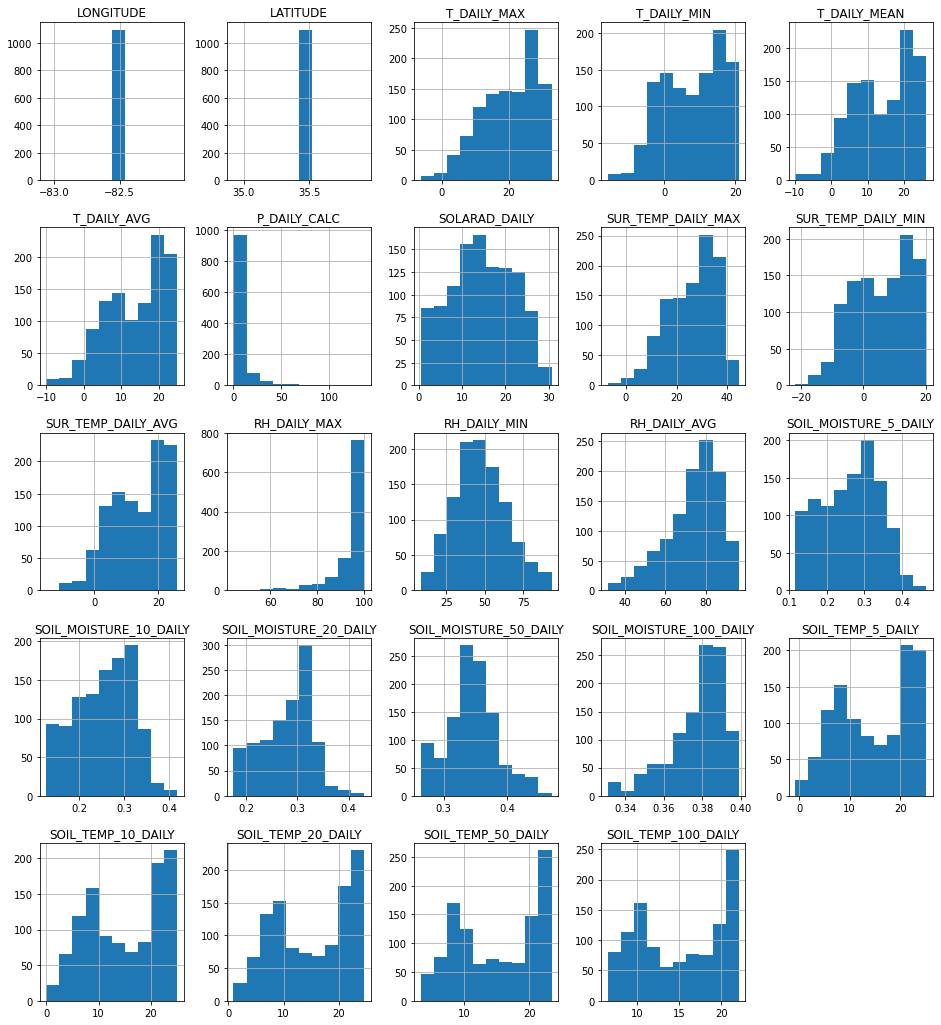

In [14]:
rcParams['figure.figsize'] = 16, 18
df[quantitative].hist()

Look more closely into P_DAILY_CALC - Total amount of precipitation (mm)

In [15]:
df['P_DAILY_CALC'].value_counts()

0.0     670
0.3      19
0.6      13
0.4      12
1.0      11
       ... 
31.6      1
31.7      1
23.7      1
20.5      1
9.6       1
Name: P_DAILY_CALC, Length: 216, dtype: int64

In [16]:
df[df['P_DAILY_CALC']>0.0]['P_DAILY_CALC'].describe()

count    423.000000
mean      11.821277
std       16.055256
min        0.200000
25%        1.500000
50%        5.800000
75%       15.850000
max      136.400000
Name: P_DAILY_CALC, dtype: float64

Majority on the days contains no rain, therefore we could add new features related to wet & dry days.

Histogram for rainy days

<AxesSubplot:>

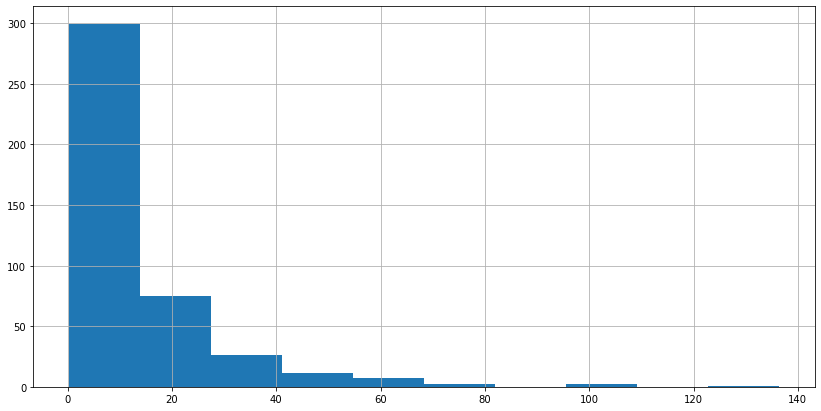

In [17]:
fig = plt.figure(figsize = (14,7))
ax = fig.gca()
df[df['P_DAILY_CALC']>0.0]['P_DAILY_CALC'].hist(ax = ax)

## Data transformation -  Feature engineering

### Add new features for year, month, day

In [18]:
# Date transformation
df['year'] = df['LST_DATE'].dt.year
df['month'] = df['LST_DATE'].dt.month
df['day'] = df['LST_DATE'].dt.day
df['dayofweek'] = df['LST_DATE'].dt.weekday

In [19]:
df.head()

,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,year,month,day,dayofweek
0,53878,2017-01-01,2.422,-82.56,35.42,11.7,4.9,8.3,7.6,0.6,...,0.331,6.8,6.7,7.0,8.5,10.8,2017,1,1,6
1,53878,2017-01-02,2.422,-82.56,35.42,12.2,7.2,9.7,9.4,13.0,...,0.331,8.6,8.4,8.3,8.6,10.7,2017,1,2,0
2,53878,2017-01-03,2.422,-82.56,35.42,16.5,8.0,12.3,10.9,9.7,...,0.331,9.8,9.5,9.2,9.0,10.6,2017,1,3,1
3,53878,2017-01-04,2.422,-82.56,35.42,11.9,-1.0,5.4,6.0,0.0,...,0.331,8.8,9.0,9.3,9.4,10.6,2017,1,4,2
4,53878,2017-01-05,2.422,-82.56,35.42,7.5,-4.8,1.3,1.6,0.0,...,0.332,6.1,6.6,7.6,9.2,10.6,2017,1,5,3


### Add categorical new feature for rainy days

#### Add rainy (Wet/Dry) new features

In [20]:
# Categorical rainy feature
df['rainy'] = 'Wet'
df.loc[df['P_DAILY_CALC']==0.0,'rainy'] = 'Dry'
df['Dry'] = 0
df.loc[df['P_DAILY_CALC']==0.0,'Dry'] = 1
df['Wet'] = 0
df.loc[df['P_DAILY_CALC']!=0.0,'Wet'] = 1

In [21]:
df['rainy'].value_counts()

Dry    670
Wet    425
Name: rainy, dtype: int64

#### Add rain label new feature using bins

In [22]:
bins = [0, 1, 10, 20, 40, 110]
labels = ['No rain', 'Drizzle', 'Light rain', 'Moderate rain', 'Heavy rain']
df['rain_label'] = pd.cut(df.P_DAILY_CALC, bins, labels=labels, include_lowest=True)

In [23]:
df['rain_label'].value_counts()

No rain          763
Drizzle          165
Light rain        84
Moderate rain     58
Heavy rain        22
Name: rain_label, dtype: int64

<AxesSubplot:xlabel='count', ylabel='rain_label'>

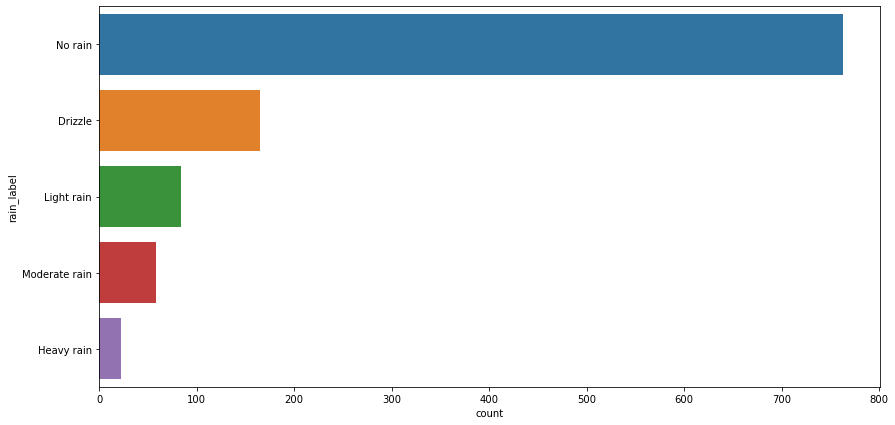

In [24]:
rcParams['figure.figsize'] = 14, 7
sns.countplot(y=df['rain_label'])

Comparing Solar energy(radiance) with rain type

[Text(0.5, 0, 'Rain intensity'),
 Text(0, 0.5, 'Solar energy'),
 Text(0.5, 1.0, 'Comparing Solar energy(radiance) with rain type')]

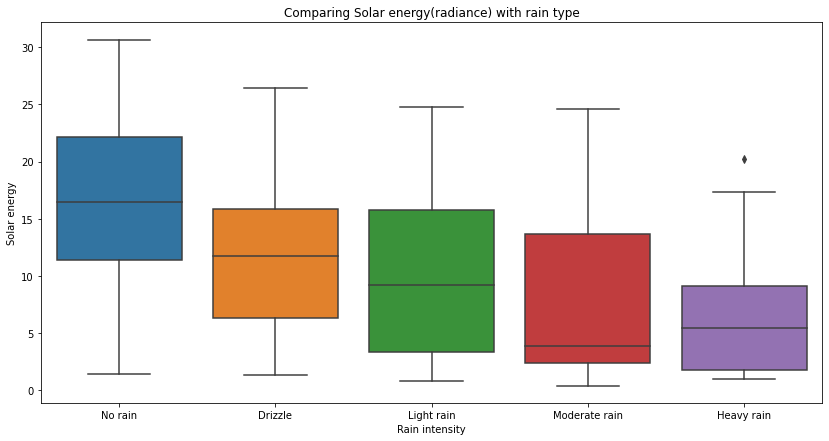

In [25]:
sns.boxplot(x=df['rain_label'], y=df['SOLARAD_DAILY']).set(
    xlabel='Rain intensity', 
    ylabel='Solar energy',
    title='Comparing Solar energy(radiance) with rain type'
)

Comparing Solar energy(radiance) with Average air temperature

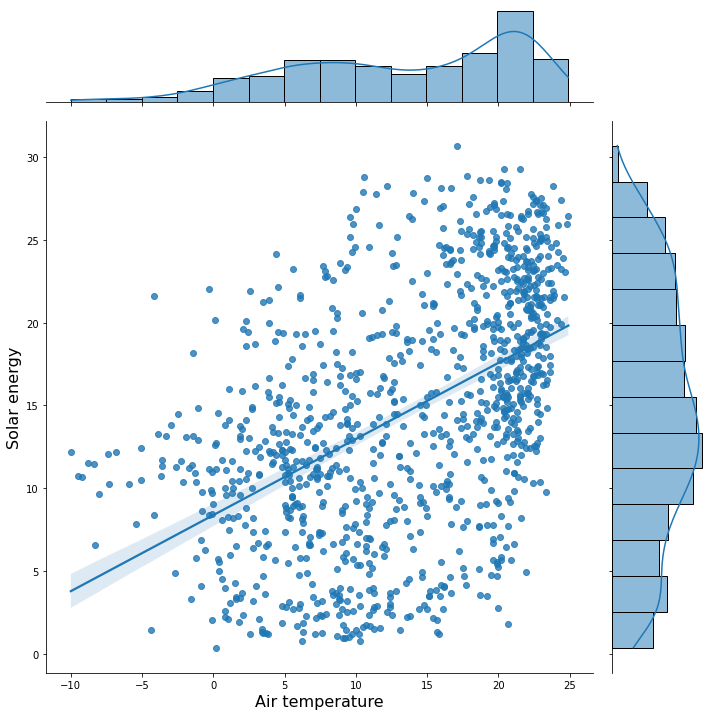

In [26]:
jointplot = sns.jointplot(data=df, x="T_DAILY_AVG", y="SOLARAD_DAILY", kind="reg", height=10)
jointplot.set_axis_labels('Air temperature', 'Solar energy', fontsize=16)

We can notice little correlation between these two variables, lets have a look to overall correlations between main variable in the next section.

## Data Exploration

### Overall Correlations

In [27]:
correlations_vars=['rainy','T_DAILY_AVG', 'P_DAILY_CALC', 'SOLARAD_DAILY', 'SUR_TEMP_DAILY_AVG', 'RH_DAILY_AVG', 
              'SOIL_MOISTURE_5_DAILY', 'SOIL_TEMP_5_DAILY']
df[correlations_vars].head()

,rainy,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,SUR_TEMP_DAILY_AVG,RH_DAILY_AVG,SOIL_MOISTURE_5_DAILY,SOIL_TEMP_5_DAILY
0,Wet,7.6,0.6,2.29,8.1,89.1,0.196,6.8
1,Wet,9.4,13.0,2.54,9.9,93.7,0.237,8.6
2,Wet,10.9,9.7,5.47,10.5,89.5,0.262,9.8
3,Dry,6.0,0.0,4.74,4.1,66.7,0.247,8.8
4,Dry,1.6,0.0,6.51,1.2,57.5,0.239,6.1


#### Correlation Matrix

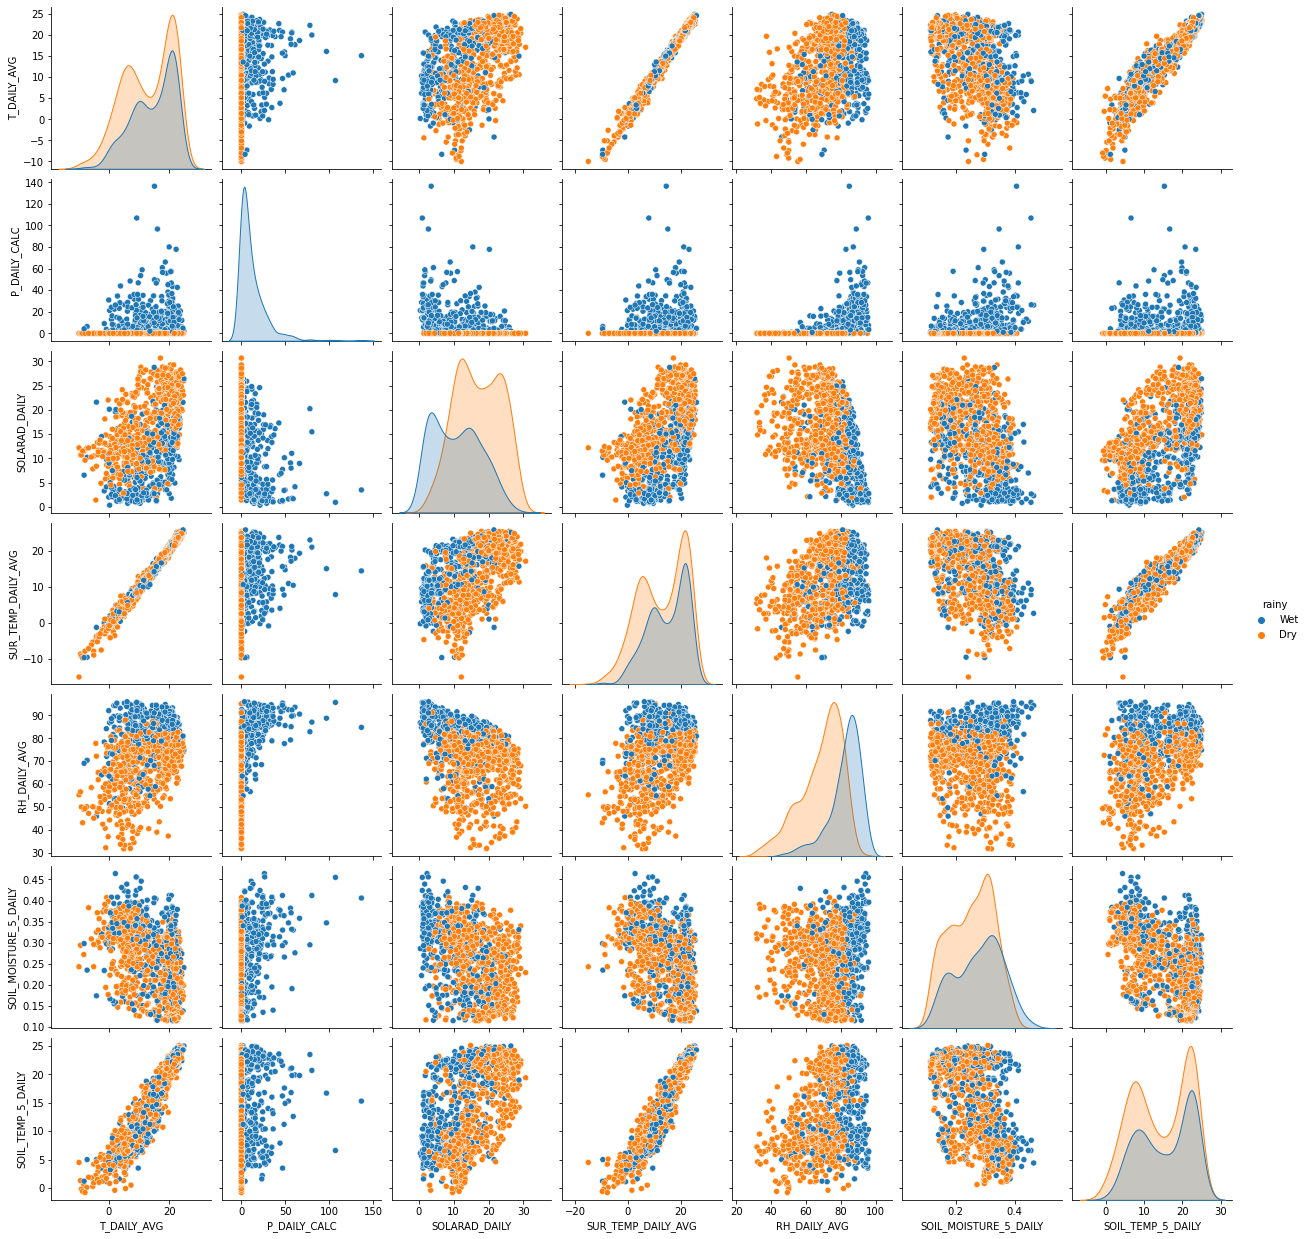

In [28]:
sns.pairplot(df[correlations_vars], hue='rainy')

A couple of observations from the correlation matrix:
- strong correlation between air temperature and soil temperature and also with infrared surface temperature
- little correlation between solar energy and humidity
- little correlation between soil moisture and infrared surface temperature
- air humidity is not correlated with air temperature 


### Visualizations by Date

#### Index by date

In [29]:
df_idx = df.set_index('LST_DATE')
df_idx.head()

,WBANNO,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,...,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,year,month,day,dayofweek,rainy,Dry,Wet,rain_label
LST_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,53878,2.422,-82.56,35.42,11.7,4.9,8.3,7.6,0.6,2.29,...,8.5,10.8,2017,1,1,6,Wet,0,1,No rain
2017-01-02,53878,2.422,-82.56,35.42,12.2,7.2,9.7,9.4,13.0,2.54,...,8.6,10.7,2017,1,2,0,Wet,0,1,Light rain
2017-01-03,53878,2.422,-82.56,35.42,16.5,8.0,12.3,10.9,9.7,5.47,...,9.0,10.6,2017,1,3,1,Wet,0,1,Drizzle
2017-01-04,53878,2.422,-82.56,35.42,11.9,-1.0,5.4,6.0,0.0,4.74,...,9.4,10.6,2017,1,4,2,Dry,1,0,No rain
2017-01-05,53878,2.422,-82.56,35.42,7.5,-4.8,1.3,1.6,0.0,6.51,...,9.2,10.6,2017,1,5,3,Dry,1,0,No rain


#### Showing number of Dry/Wet days per month

Text(0, 0.5, 'Number of days')

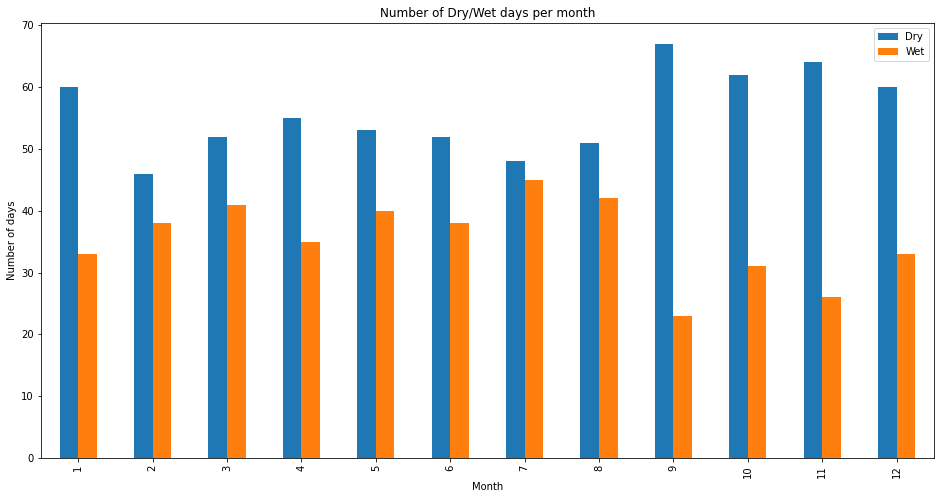

In [30]:
rcParams['figure.figsize'] = 16, 8
df_idx.groupby(df_idx.index.month).aggregate({'Dry': 'sum', 'Wet': 'sum'}).plot(kind='bar', title='Number of Dry/Wet days per month')
plt.xlabel('Month')
plt.ylabel('Number of days')

#### Average air temperature by date

Text(0, 0.5, 'Air temperature')

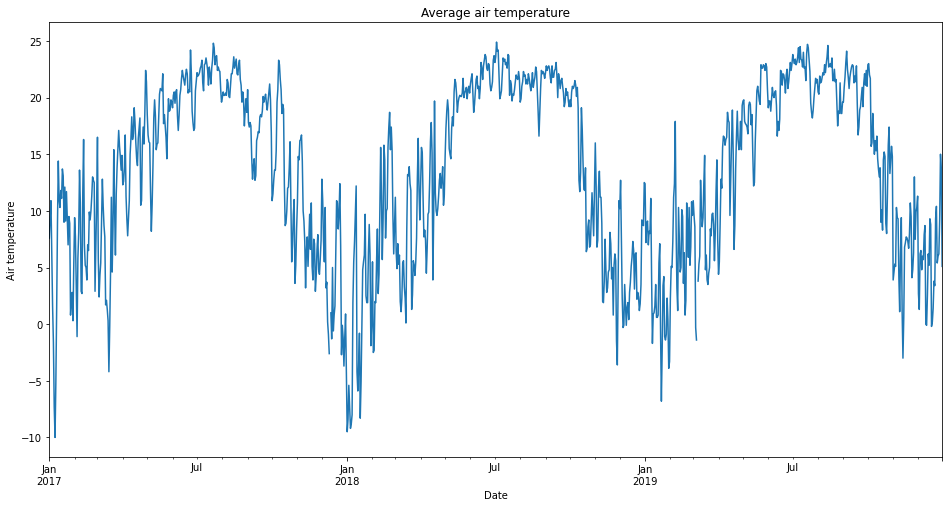

In [31]:
df_idx.T_DAILY_AVG.plot(title='Average air temperature')
plt.xlabel('Date')
plt.ylabel('Air temperature')

We can notice sesonability, air temperature varies with the seasons

#### Average values in each month of the year

In [32]:
monthly_avg = df_idx.groupby(df_idx.index.month).mean()
monthly_avg

,WBANNO,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,...,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,year,month,day,dayofweek,Dry,Wet
LST_DATE,,,,,,,,,,,,,,,,,,,,,
1,53878.0,2.422000,-82.56,35.42,8.726882,-2.345161,3.189247,3.067742,3.719355,8.386237,...,5.258065,5.659140,6.686022,8.697849,2018.0,1.0,16.0,2.881720,0.645161,0.354839
2,53878.0,2.422000,-82.56,35.42,14.720238,1.976190,8.348810,8.172619,4.195238,9.972024,...,7.890476,7.884524,7.744048,8.388095,2018.0,2.0,14.5,3.000000,0.547619,0.452381
3,53878.0,2.477914,-82.56,35.42,13.804348,1.670652,7.741304,7.711957,2.814130,14.556522,...,8.878261,8.951087,8.964130,9.461957,2018.0,3.0,16.0,3.096774,0.559140,0.440860
4,53878.0,2.488667,-82.56,35.42,20.217778,6.812222,13.508889,13.647778,5.996667,17.840111,...,13.977778,13.763333,12.848889,11.860000,2018.0,4.0,15.5,3.000000,0.611111,0.388889
5,53878.0,2.488667,-82.56,35.42,25.027957,12.656989,18.839785,18.637634,6.905376,20.085161,...,19.172043,18.859140,17.459140,15.574194,2018.0,5.0,16.0,2.903226,0.569892,0.430108
6,53878.0,2.488667,-82.56,35.42,27.122222,15.470000,21.300000,20.910000,4.031111,21.312778,...,21.796667,21.601111,20.535556,18.750000,2018.0,6.0,15.5,3.100000,0.577778,0.422222
7,53878.0,2.488667,-82.56,35.42,28.646237,17.402151,23.018280,22.324731,4.503226,20.575591,...,23.464516,23.335484,22.302151,20.679570,2018.0,7.0,16.0,2.935484,0.516129,0.483871
8,53878.0,2.488667,-82.56,35.42,27.475269,16.555914,22.011828,21.211828,5.409677,17.720215,...,23.008602,23.010753,22.427957,21.474194,2018.0,8.0,16.0,3.000000,0.548387,0.451613
9,53878.0,2.488667,-82.56,35.42,26.980000,14.690000,20.833333,20.081111,2.364444,15.966889,...,21.627778,21.711111,21.440000,21.050000,2018.0,9.0,15.5,3.088889,0.744444,0.255556


These values provide information about specific climate.

#### Air temperature Avg, Max and Min values per month

In [33]:
monthly_agg = df_idx.groupby(df_idx.index.month).aggregate({'T_DAILY_AVG': 'mean', 'T_DAILY_MAX': 'max', 'T_DAILY_MIN': 'min'})
monthly_agg

,T_DAILY_AVG,T_DAILY_MAX,T_DAILY_MIN
LST_DATE,,,
1,3.067742,21.4,-15.9
2,8.172619,25.9,-8.7
3,7.711957,25.8,-7.5
4,13.647778,28.8,-2.3
5,18.637634,31.7,1.9
6,20.910000,31.7,8.3
7,22.324731,31.8,11.2
8,21.211828,32.6,9.8
9,20.081111,32.6,6.3


Text(0, 0.5, 'Air temperature')

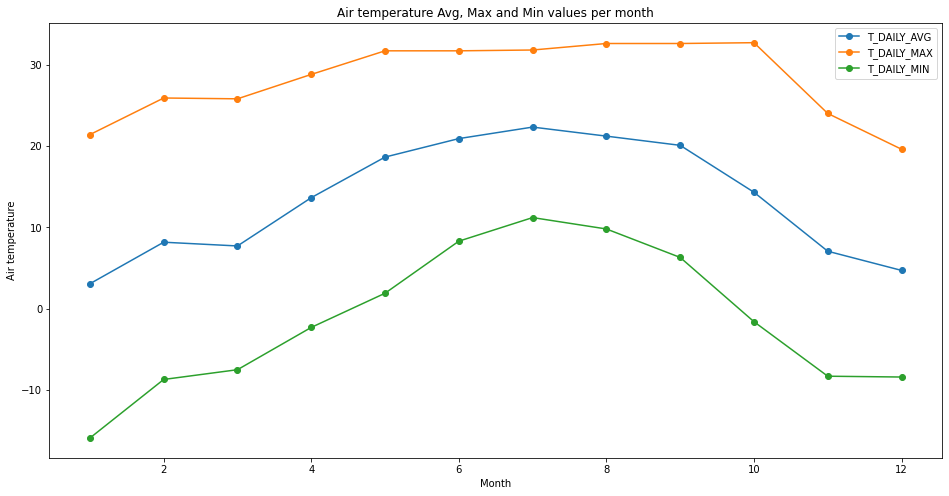

In [34]:
monthly_agg.plot(marker='o', title='Air temperature Avg, Max and Min values per month')
plt.xlabel('Month')
plt.ylabel('Air temperature')

#### Standardized air temperature by date

Text(0, 0.5, 'Standardized air temperature')

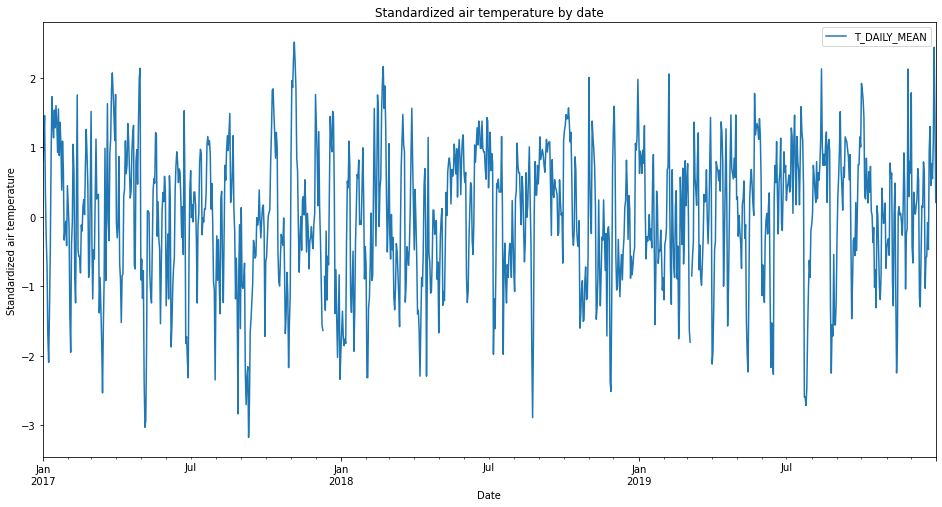

In [35]:
def standardize(x):
    return (x - x.mean())/x.std()

temp_stand = df_idx.groupby(df_idx.index.month).transform(standardize)
temp_stand.plot(y='T_DAILY_MEAN', title='Standardized air temperature by date')
plt.xlabel('Date')
plt.ylabel('Standardized air temperature')

Values less than -2 or greated than 2 might be considered as temperature anomalies

### HeatMaps

In [36]:
# Drawing a heatmap
def weather_heatmap(data, color, **kws):
    values=data.columns.values[3]
    data = data.pivot(index='month', columns='day', values=values)
    sns.heatmap(data, cmap='coolwarm', **kws)  

# Joining heatmaps of every month in a year 
def weather_calendar(weather): 
    dfyear = df[['year', 'month', 'day', weather]]
    vmin=dfyear[weather].min()
    vmax=dfyear[weather].max()
    with sns.plotting_context(font_scale=12):
        g = sns.FacetGrid(dfyear,col="year", col_wrap=3) #One heatmap per month
        g = g.map_dataframe(weather_heatmap,vmin=vmin, vmax=vmax)
        g.set_axis_labels('Day', 'Month')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('%s Calendar' %(weather))

#### Temperature heatmap

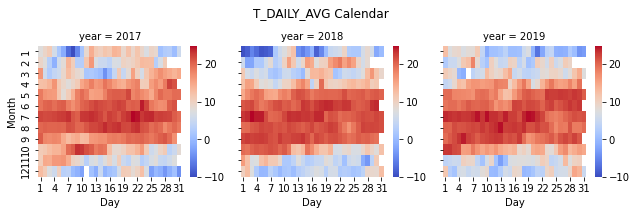

In [37]:
weather_calendar('T_DAILY_AVG')

As expected the air temperature has higher values during the summer months. 

#### Precipitation heatmap

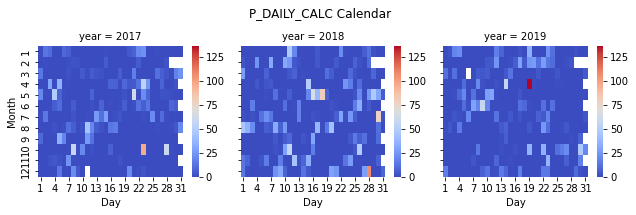

In [38]:
weather_calendar('P_DAILY_CALC')

The climate is not very rainy in Asheville.

#### Humidity heatmap

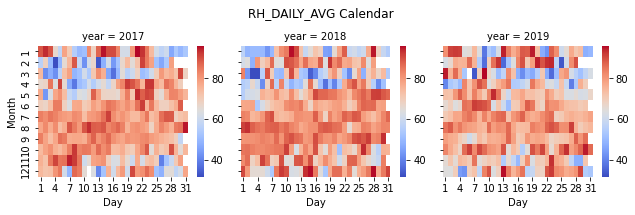

In [39]:
weather_calendar('RH_DAILY_AVG')

Even if it doesn't rain heavily, there are a lot of days with important humidity. 